## LSTM network for multi-step time series forecasting.

In [1]:
# load and plot dataset
import glob
import pandas as pd
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from numpy import array

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
###############################################################################
# read input omniture .csv files into dataframe
###############################################################################
import glob
import pandas as pd

# omniture files path
path = r'C:\Users\Raja Harsha\Documents\DE\LSTM\'

all_files = glob.glob(path + "/*.csv")
df_omniture = pd.DataFrame()
list_ = []
for f in all_files:
    df = pd.read_csv(f, index_col=None, header=0)
    list_.append(df)

df_omniture = pd.concat(list_)
df_omniture.head()

df_omniture.columns = ['zip', 'pv', 'date']

###############################################################################
# filter and calculate monthly page views for zip code data: XXXXX
###############################################################################

df_zipdata = df_omniture[df_omniture['zip'] == 'XXXXX']

# Convert that column into a datetime datatype
df_zipdata['Month'] = pd.to_datetime(df_zipdata['date'])

# Set the datetime column as the index
df_zipdata.index = df_zipdata['Month'] 

# Drop date, zip columns 
df_zipdata = df_zipdata.drop(['Month','zip'], 1)

# aggregate the daily data to monthly
df_m_zipdata = df_zipdata.resample('M').sum()

df_m_zipdata.head()

,pv
Month,
2015-03-31,525
2015-04-30,379
2015-05-31,312
2015-06-30,277
2015-07-31,445


In [3]:
df_m_zipdata.tail()

,pv
Month,
2017-02-28,220
2017-03-31,237
2017-04-30,224
2017-05-31,235
2017-06-30,264


In [4]:
series = df_m_zipdata

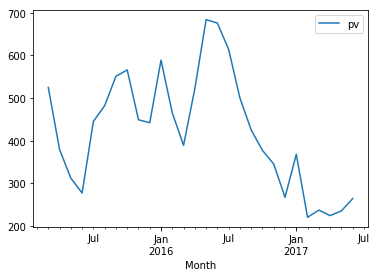

In [5]:
# line plot
series.plot()
pyplot.show()

### Multi-Step Forecast: Every 3 Months

"""
Dec,	Jan, Feb, Mar
Jan,	Feb, Mar, Apr
Feb,	Mar, Apr, May
Mar,	Apr, May, Jun
Apr, 	May, Jun, Jul
May,	Jun, Jul, Aug
Jun,	Jul, Aug, Sep
Jul,	Aug, Sep, Oct
Aug,	Sep, Oct, Nov
Sep,	Oct, Nov, Dec
"""

### Time Series for Supervised Learning Problem

In [7]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
    
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Transform Series into Test and Train Datasets

In [8]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
    
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
    
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    
	return train, test

In [9]:
# Apply Time Series Conversion and derive Test-Train Datasets here.

# configure
n_lag=1
n_seq=3
n_test=5

# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
print(test)
print('\nDatasets Shape:')
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[ 345.  267.  368.  220.]
 [ 267.  368.  220.  237.]
 [ 368.  220.  237.  224.]
 [ 220.  237.  224.  235.]
 [ 237.  224.  235.  264.]]

Datasets Shape:
Train: (20, 4), Test: (5, 4)


In [10]:
train

array([[ 525.,  379.,  312.,  277.],
       [ 379.,  312.,  277.,  445.],
       [ 312.,  277.,  445.,  482.],
       [ 277.,  445.,  482.,  551.],
       [ 445.,  482.,  551.,  566.],
       [ 482.,  551.,  566.,  449.],
       [ 551.,  566.,  449.,  442.],
       [ 566.,  449.,  442.,  589.],
       [ 449.,  442.,  589.,  465.],
       [ 442.,  589.,  465.,  389.],
       [ 589.,  465.,  389.,  522.],
       [ 465.,  389.,  522.,  684.],
       [ 389.,  522.,  684.,  676.],
       [ 522.,  684.,  676.,  614.],
       [ 684.,  676.,  614.,  500.],
       [ 676.,  614.,  500.,  425.],
       [ 614.,  500.,  425.,  377.],
       [ 500.,  425.,  377.,  345.],
       [ 425.,  377.,  345.,  267.],
       [ 377.,  345.,  267.,  368.]])

In [11]:
test

array([[ 345.,  267.,  368.,  220.],
       [ 267.,  368.,  220.,  237.],
       [ 368.,  220.,  237.,  224.],
       [ 220.,  237.,  224.,  235.],
       [ 237.,  224.,  235.,  264.]])

### Make Persistence Forecasts

In [12]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

In [13]:
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [14]:
# call forecasting function
forecasts = make_forecasts(train, test, 1, 3)

In [15]:
forecasts

[[345.0, 345.0, 345.0],
 [267.0, 267.0, 267.0],
 [368.0, 368.0, 368.0],
 [220.0, 220.0, 220.0],
 [237.0, 237.0, 237.0]]

### Evaluate Forecasts

Calculate RMSE for each time step of multi-step forecast, this gives us 3 RMSE scores.

In [16]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [17]:
evaluate_forecasts(test, forecasts, 1, 3)

t+1 RMSE: 87.917006
t+2 RMSE: 63.117351
t+3 RMSE: 87.424253


### Plotting Forecasts

In [18]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - 7 + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

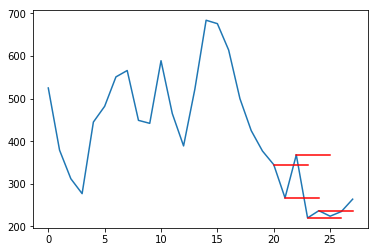

In [19]:
# plot forecasts
plot_forecasts(series, forecasts, 7)

Line plot of sales dataset with multi-step persistence forecasts. <br>
The context shows how naive the persistence forecasts actually are.

## Multi-Step LSTM Network

### Data Preparation: Stationarizing and Scaling

In [20]:
# stationarizing
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [21]:
# scaling
# we can use the MinMaxScaler from the sklearn library to scale the data.

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [22]:
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

In [23]:
test

array([[-0.26582278, -0.55696203,  0.57594937, -1.        ],
       [-0.55696203,  0.57594937, -1.        ,  0.0443038 ],
       [ 0.57594937, -1.        ,  0.0443038 , -0.14556962],
       [-1.        ,  0.0443038 , -0.14556962,  0.00632911],
       [ 0.0443038 , -0.14556962,  0.00632911,  0.12025316]])

### Fit LSTM Network

In [24]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [25]:
# fit model
model = fit_lstm(train, 1, 3, 1, 1000, 1)

### Make LSTM Forecasts

In [26]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [27]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [28]:
# make forecasts
forecasts = make_forecasts(model, 1, train, test, 1, 3)

### Invert Transforms

In [29]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [30]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [31]:
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)

In [32]:
# calculate RMSE values
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

In [33]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [34]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 81.607839
t+2 RMSE: 66.928249
t+3 RMSE: 89.251600


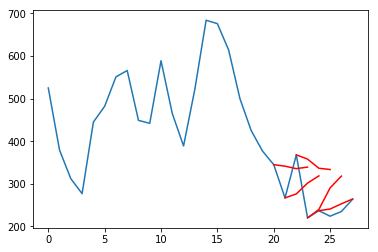

In [35]:
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

In [36]:
actual

[[array([ 267.]), array([ 368.]), array([ 220.])],
 [array([ 368.]), array([ 220.]), array([ 237.])],
 [array([ 220.]), array([ 237.]), array([ 224.])],
 [array([ 237.]), array([ 224.]), array([ 235.])],
 [array([ 224.]), array([ 235.]), array([ 264.])]]

In [37]:
forecasts

[[array([ 341.48115373]), array([ 335.62271667]), array([ 339.28390074])],
 [array([ 276.35158253]), array([ 301.75579548]), array([ 318.67817974])],
 [array([ 358.05258751]), array([ 336.57897186]), array([ 333.61640525])],
 [array([ 239.77188492]), array([ 290.48731613]), array([ 318.14638329])],
 [array([ 240.91513729]), array([ 253.11406326]), array([ 264.43494034])]]

In [40]:
abs_error = []
for i in [0,1,2,3,4]:
    for j in [0]:
        diff = (actual[i][j][0] - forecasts[i][j][0])*100/(actual[i][j][0])
        abs_error.append(abs(diff))
        print (diff)

# absolute mean error
import numpy as np
np.mean(abs_error)

-27.8955631935
24.9044612698
-62.7511761405
-1.16957169545
-7.55140057632


24.854434575112144